In [8]:
import random
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath('..'))

import random
from src import *

def coin(p: float) -> float:
    return 1 if random.random() < p else 0

In [9]:
def high_variance():
    if coin(0.5):
        return 10
    return -10

def low_variance():
    if coin(0.5):
        return 1
    return -1

program = Profile(Mul(Sampler(NamedCallable(lambda: high_variance(), "fn1(High Variance)")), Add(Sampler(NamedCallable(lambda: low_variance(), "fn2(Low Variance)")), Exact(10))))

num_samples = 10000

print("Mean: ", Dist(program,num_samples).estimate(), "Variance: ", Dist(program.variance(),num_samples).estimate())
print("Summary:\n", program.summary())

Mean:  -1.084 Variance:  10092.2
Summary:
 ('fn1(High Variance)', 20): (30000, 2.4010116079201303e-07)
('fn2(Low Variance)', 21): (30000, 2.393668769703557e-07)
('fn1(High Variance).variance', 22): (20000, 5.676203203620389e-07)
('fn2(Low Variance).variance', 23): (20000, 5.692805774742737e-07)



In [10]:
n = 10000

# progs
no_bias_variance = Dist(program.variance(), n)
bad_bias_variance = Dist(program.variance(adaptive=True), n)
good_bias_variance = Dist(program.variance(adaptive=True), n)

# envs
opt_bias = minimize_variance(program)
bad_bias = {env_var:0.5 for env_var in opt_bias}

# record
import copy
def mean_record(x: IntractableReal, env=None) -> (float, ProfileData):
    env = env or {}
    program.clear()
    mean = x.estimate(env)
    profile_copy = copy.deepcopy(program.profile_data.data)
    return (mean, profile_copy)


# List of experiments: each is (label, variance_expr, env)
all_tasks = [
    ("No Bias", no_bias_variance, {}),
    ("Suboptimal Bias", bad_bias_variance, bad_bias),
    ("Good Bias", good_bias_variance, opt_bias),
]

results = []

for label, vexpr, env in all_tasks:
    mean, profile_copy = mean_record(vexpr,env)
    results.append((label, mean, profile_copy))

print(results)


[('No Bias', 10001.18, {('fn1(High Variance).variance', 24): [20000, 0.00797894928837195], ('fn2(Low Variance).variance', 25): [20000, 0.007781927532050759], ('fn2(Low Variance)', 21): [20000, 0.003039733855985105], ('fn1(High Variance)', 20): [20000, 0.0030713389278389513]}), ('Suboptimal Bias', 10228.0, {('fn1(High Variance).variance', 26): [7470, 0.0029738047742284834], ('fn2(Low Variance)', 21): [4988, 0.0008198207360692322], ('fn2(Low Variance).variance', 27): [3739, 0.0014714889111928642], ('fn1(High Variance)', 20): [5060, 0.0007713068625889719]}), ('Good Bias', 8450.997883534923, {('fn2(Low Variance).variance', 29): [9618, 0.0036665963125415146], ('fn1(High Variance)', 20): [19254, 0.0028908541426062584], ('fn1(High Variance).variance', 28): [373, 0.00014142703730612993], ('fn2(Low Variance)', 21): [366, 5.3140276577323675e-05]})]


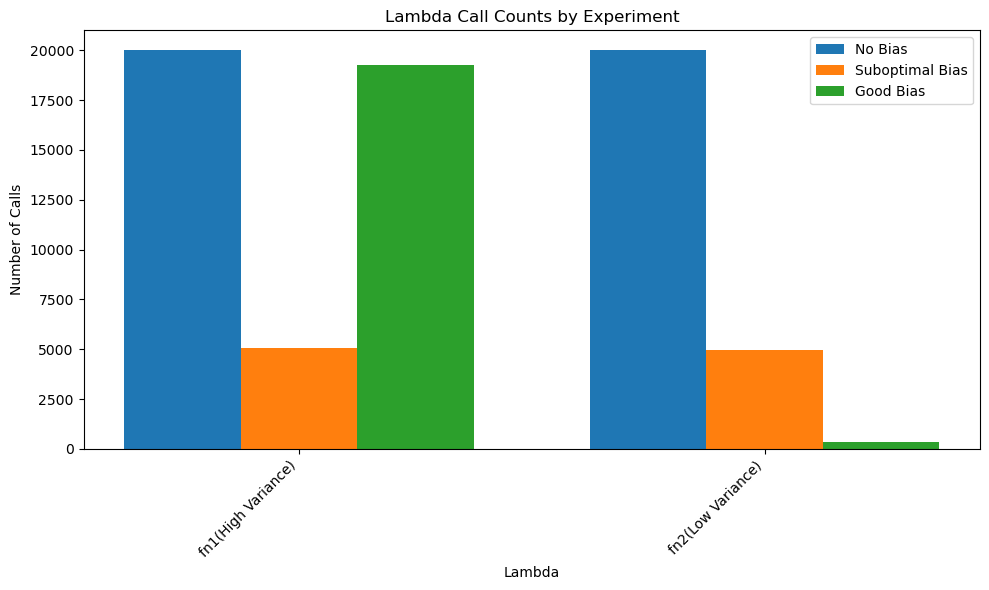

In [ ]:
# Plot
import numpy as np
import matplotlib.pyplot as plt

# Extract lambda names, filtering out those ending with '.variance'
# These are proportional to original calls and are distracting for plot - WP

lambda_names = sorted(
    set(
        name
        for _, _, prof in results
        for (name, _) in prof.keys()
        if not name.endswith(".variance")
    )
)

# Build count data for each experiment
counts_by_task = {}
for label, mean, prof in results:
    counts_by_task[label] = {name: 0 for name in lambda_names}
    for (name, uid), (count, time) in prof.items():
        if name in lambda_names:
            counts_by_task[label][name] = count

# Create grouped bar chart
x = np.arange(len(lambda_names))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))

for i, (label, _, _) in enumerate(results):
    counts = [counts_by_task[label][name] for name in lambda_names]
    offset = (i - 1) * width  # Centers the 3 bars around each x position
    ax.bar(x + offset, counts, width, label=label)

ax.set_xlabel('Lambda')
ax.set_ylabel('Number of Calls')
ax.set_title('Lambda Call Counts by Experiment')
ax.set_xticks(x)
ax.set_xticklabels(lambda_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()
